In [1]:
import pandas as pd
from tables import *
import numpy as np
from tqdm import tqdm_notebook as tqdm
import csv
from scipy import sparse
import pickle
import os

In [2]:
path = '/home/User1/data/self_citations/'

In [3]:
min_year = 1980
max_year = 2020
nb_years = max_year-min_year

In [4]:
disciplines = pd.read_csv(path+'liste_discipline.txt',encoding='latin_1',sep='\t')
list_disciplines = pd.unique(disciplines['EDiscipline'])
nb_disciplines = len(list_disciplines)

In [5]:
from matplotlib import pyplot as plt

In [6]:
types_cit = ['self','co','others','network']

authors_info = {}
with open(path+'model/authors_infos_model.csv','r') as f:
    reader = csv.reader(f,delimiter='\t')
    next(reader)
    for line in reader:
        authors_info[int(line[0])] = [line[1],int(line[2]),int(line[4]),int(line[3])]

#Map to auth ID
with open(path+'authors_disc.p','rb') as f:
    authors_disc_idx = pickle.load(f)

#Keys:idx,values:authorID
for disc in list_disciplines:
    authors_disc_idx[disc] = {authors_disc_idx[disc][x]:x for x in authors_disc_idx[disc]}

In [7]:
disc_groups = {'Arts and Humanities':['Arts','Humanities'],
              'Natural Sciences and Engineering':['Biology','Physics','Mathematics','Engineering and Technology','Earth and Space','Chemistry'],
              'Social Sciences':['Social Sciences','Psychology','Professional Fields','Health'],
             'Health Sciences':['Biomedical Research','Clinical Medicine']}

nb_groups = len(disc_groups)
group_names = list(disc_groups.keys())

In [8]:
def hIndex(citations):
        """
        :type citations: List[int]
        :rtype: int
        """
        citations = list(citations)
        if not citations:
            return 0
        citations.sort()
        for i in range(1,len(citations)+1)[::-1]:
            if citations[-i] >= i:
                return i
        return 0

In [9]:
bins_nb_pubs = [1,2,3,4,5,7,10,15,20,25,30,40,50,70,100,150,200,300,500,750,1000,1500,2000,2500,3000,4000]
nb_bins = len(bins_nb_pubs)
bins_lbl = bins_nb_pubs.copy()
bins_lbl[-6:] = ['1k','1.5k','2k','2.5k','3k','4k']

In [10]:
diff_pubs = np.diff(bins_nb_pubs)

In [11]:
labels = []
for i in range(nb_bins-1):
    diff = diff_pubs[i]-1
    bin_val = bins_nb_pubs[i+1]
    if diff == 0:
        labels.append(str(bin_val) + ' papers')
    else:
        labels.append('{}-{} papers'.format(str(bin_val),str(bin_val+diff)))
    

#### cols 1

In [12]:
colors = [np.array([52,47,73]),
         np.array([47,73,60]),
         np.array([95,170,133]),
          np.array([206,250,134])
         ]
colors = [x/255 for x in colors]

#### cols 2

In [13]:
colors = [
     np.array([53,116,172]),
    np.array([44,164,40]),
        
         np.array([164,186,183]),
          np.array([255,232,31])
         ]
colors = [x/255 for x in colors]

### Abs adn rel citations

In [95]:
for i in tqdm(range(nb_groups)):
    group = group_names[i]   
    disc_group = disc_groups[group]
    arrays_cits = {}
    li = []

    citations = {}
    for disc in disc_group:
        with open('{}/arrays/citations_articles_{}.p'.format(path,disc),'rb') as f:
            load_cit = pickle.load(f)
            citations.update(load_cit)

    authors = list(citations.keys())
    nb_authors = len(authors)
    #0:Others,1:Others+net,2:Others+co+net,3:Others+co+net+self
    for j in range(nb_authors):
        ID_author = authors[j]
        data_author = citations[ID_author]
        if len(data_author) == 0:
            continue
        cits_author = data_author['citations']
        cits_o = cits_author[:,3]
        cits_on = np.sum(cits_author[:,2:4],axis=1)
        cits_onc = np.sum(cits_author[:,1:4],axis=1)
        cits_oncs = np.sum(cits_author[:,:4],axis=1)
        h_o = hIndex(cits_o)
        h_on = hIndex(cits_on)
        h_onc = hIndex(cits_onc)
        h_oncs = hIndex(cits_oncs)
        nb_pubs = cits_author.shape[0]
        li.append([ID_author,nb_pubs,h_o,h_on,h_onc,h_oncs])
    
    df = pd.DataFrame(li,columns=['ID_author','nb_pubs','h_o','h_on','h_onc','h_oncs'])
    df = df.dropna()
    df['d_s'] = df['h_oncs']-df['h_onc']
    df['d_sc'] = df['h_oncs']-df['h_on']
    
    df['binned_pub'] = pd.cut(df['nb_pubs'],bins_nb_pubs)
    df['binned_pub'] = df['binned_pub'].apply(lambda x: int(x.right))
    stats = df.groupby('binned_pub').agg({'h_o':'mean','h_on':'mean','h_onc':'mean',
                                          'h_oncs':'mean','d_s':'mean','d_sc':'mean'}).reset_index()
    

    plt.figure(figsize=(8,7.5))
    for k in range(2):
        ax = plt.subplot(2,1,k+1)
        if k == 0:
            max_art = 15
            s = 0
            e = np.where(np.array(bins_nb_pubs)==max_art)[0][0] 
            plt.title(group,fontsize=14)
        else:
            s = e
            e = nb_bins

        plt.plot(stats['binned_pub'][s:e],stats['h_o'][s:e],label='Others',color=colors[0],linewidth=3)
        plt.plot(stats['binned_pub'][s:e],stats['h_on'][s:e],label='Others+Coll.',color=colors[1],linewidth=3)
        plt.plot(stats['binned_pub'][s:e],stats['h_onc'][s:e],label='Others+Coll.+Co.',color=colors[2],linewidth=3)
        plt.plot(stats['binned_pub'][s:e],stats['h_oncs'][s:e],label='Others+Coll.+Co.+Self',color=colors[3],linewidth=3)
        plt.xticks(np.arange(nb_bins-1)[s:e],bins_lbl[1:][s:e])
        plt.ylabel('h-index',fontsize=12)
        plt.xlabel('# publications',fontsize=12)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

        plt.tick_params(labelsize=12)

    plt.legend()
    out_path = path+'results/h-index/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + group + '_abs-index.png')
    plt.savefig(out_path + group + '_abs-index.svg')
    plt.close()
    
    plt.figure(figsize=(8,7.5))
    for k in range(2):
        ax = plt.subplot(2,1,k+1)
        if k == 0:
            max_art = 15
            s = 0
            e = np.where(np.array(bins_nb_pubs)==max_art)[0][0] 
            plt.title(group,fontsize=14)
        else:
            s = e
            e = nb_bins
        plt.plot(stats['binned_pub'][s:e],stats['d_s'][s:e],label='All - Self',color='r',linewidth=3)
        plt.plot(stats['binned_pub'][s:e],stats['d_sc'][s:e],label='All - Self - Co.',color='b',linewidth=3)
        plt.xticks(np.arange(nb_bins-1)[s:e],bins_lbl[1:][s:e])
        plt.ylabel('Delta h-index',fontsize=12)
        plt.xlabel('# publications',fontsize=12)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

        plt.tick_params(labelsize=12)
    plt.legend()
    out_path = path+'results/h-index/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + group + '_rel-index.png')
    plt.savefig(out_path + group + '_rel-index.svg')
    plt.close()
    
    

/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


A Jupyter Widget

### Bootstrap

In [15]:
from scipy import stats
nb_samples = 100

In [33]:
plt.close()

In [35]:
for i in tqdm(range(nb_groups)):
    group = group_names[i]   
    disc_group = disc_groups[group]
    arrays_cits = {}
    li = []

    citations = {}
    for disc in disc_group:
        with open('{}/arrays/citations_articles_{}.p'.format(path,disc),'rb') as f:
            load_cit = pickle.load(f)
            citations.update(load_cit)

    authors = list(citations.keys())
    nb_authors = len(authors)
    #0:Others,1:Others+net,2:Others+co+net,3:Others+co+net+self
    for j in tqdm(range(nb_authors)):
        ID_author = authors[j]
        data_author = citations[ID_author]
        if len(data_author) == 0:
            continue
        cits_author = data_author['citations']
        nb_pubs = cits_author.shape[0]
        cits_o = cits_author[:,3]
        cits_on = np.sum(cits_author[:,2:4],axis=1)
        cits_onc = np.sum(cits_author[:,1:4],axis=1)
        cits_oncs = np.sum(cits_author[:,:4],axis=1)

        nb_self_cits = np.sum(cits_author[:,0])
        boot_h = []
        h_o = hIndex(cits_o)
        h_on = hIndex(cits_on)
        h_onc = hIndex(cits_onc)
        h_oncs = hIndex(cits_oncs)
        if nb_self_cits > 0:
#             #Uniform
#             for ii in range(nb_samples):
#                 draw = np.random.choice(np.arange(nb_pubs),nb_self_cits)
#                 boot_cits_s = np.bincount(draw,minlength=nb_pubs) 
#                 boot_cits_oncs = cits_onc + boot_cits_s
#                 boot_h.append(hIndex(boot_cits_oncs))
                
            #Shuffle
            for ii in range(nb_samples):
                boot_cits_s = cits_author[:,0].copy()
                np.random.shuffle(boot_cits_s)
                boot_cits_oncs = cits_onc + boot_cits_s
                boot_h.append(hIndex(boot_cits_oncs))   
                
            boot_h = np.array(boot_h)    
            
#             boot_h_mean = len(np.where(boot_h<=h_oncs)[0])/nb_samples
#             all_v = np.unique(boot_h)
#             nb_v = len(all_v)
            
#             if nb_v%2 == 1:
#                 middle_v = all_v[int(nb_v/2)]
#                 if middle_v == h_oncs:
            nb_smaller = len(np.where(boot_h<h_oncs)[0])/nb_samples
            nb_equal = len(np.where(boot_h==h_oncs)[0])/nb_samples/2
            boot_h_mean = nb_smaller + nb_equal
        else:
            continue


        li.append([ID_author,nb_pubs,h_o,h_on,h_onc,h_oncs,boot_h_mean])

    df = pd.DataFrame(li,columns=['ID_author','nb_pubs','h_o','h_on','h_onc','h_oncs','prob_h_oncs'])
    df = df.dropna()
    #df['d_boot_s'] = df['h_oncs'] - df['h_boot_s'] 
    df['d_s'] = df['h_oncs']-df['h_onc']

    df['binned_pub'] = pd.cut(df['nb_pubs'],bins_nb_pubs)
    df['binned_pub'] = df['binned_pub'].apply(lambda x: int(x.right))
    df_stats = df.groupby('binned_pub').agg({'prob_h_oncs':'mean'}).reset_index()
    
    plt.figure(figsize=(8,6))
    for k in range(2):
        plt.subplot(2,1,k+1)
        if k == 0:
            max_art = 15
            s = 0
            e = np.where(np.array(bins_nb_pubs)==max_art)[0][0] 
            plt.title(group)
        else:
            s = e
            e = nb_bins

        plt.plot(df_stats['binned_pub'][s:e],df_stats['prob_h_oncs'][s:e],label='All - Self',color='k')
        plt.xticks(np.arange(nb_bins-1)[s:e],bins_lbl[1:][s:e])
        plt.ylabel('Percentile')
        plt.xlabel('# publications')
    plt.legend()
    out_path = path+'results/h-index/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + group + '_random-index.png')
    plt.savefig(out_path + group + '_random-index.svg')
    
    plt.figure(figsize=(33,33))
    for bin_i in range(1,nb_bins):
        bin_val = bins_nb_pubs[bin_i]
        bin_lbl = labels[bin_i-1]
        df_hist = df.loc[df['binned_pub']==bin_val]

        ax = plt.subplot(5,5,bin_i)
        avg_perc = df.groupby('d_s').agg({'prob_h_oncs':'mean'}).reset_index()
        x_avg = avg_perc['d_s']
        y_avg = avg_perc['prob_h_oncs']
        
        x = np.array(df_hist['d_s'])
        x_plot = x + np.random.normal(0, 0.08, len(x))
        y = np.array(df_hist['prob_h_oncs'])
        if len(df_hist) > 0:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
            slope_avg, intercept_avg, r_value_avg, p_value_avg, std_err_avg = stats.linregress(x_avg,y_avg)
            line = slope_avg*x_avg+intercept_avg
            plt.plot(x_avg, line, 'b', label='r={:.2f}, p={:.3f}'.format(r_value,p_value))
            #end

            plt.scatter(x_plot,y, color="k", s=2,alpha=0.4)
            plt.legend(fontsize=14)     

        plt.title(bin_lbl,fontsize=18)

        # Hide the right and top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        plt.tick_params(labelsize=15)

        plt.xlabel('Delta h-index (self)',fontsize=16)
        plt.ylabel('Percentile',fontsize=16)
    
    out_path = path+'results/h-index/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + group + '_corr_dist-index.png')
    plt.savefig(out_path + group + '_corr_dist-index.svg')


/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


A Jupyter Widget

/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


A Jupyter Widget

/home/User1/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/User1/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/User1/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/User1/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/User1/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/User1/anaconda3/lib/python3.6/site-packag

A Jupyter Widget

/home/User1/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/User1/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/User1/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


A Jupyter Widget

/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


A Jupyter Widget

#### Bootstrap corr

In [91]:
from scipy import stats
nb_samples = 100

In [ ]:
for i in tqdm(range(nb_groups)):
    group = group_names[i]   
    disc_group = disc_groups[group]
    arrays_cits = {}
    li = []

    citations = {}
    for disc in disc_group:
        with open('{}/arrays/citations_articles_{}.p'.format(path,disc),'rb') as f:
            load_cit = pickle.load(f)
            citations.update(load_cit)

    authors = list(citations.keys())
    nb_authors = len(authors)
    #0:Others,1:Others+net,2:Others+co+net,3:Others+co+net+self
    for j in range(nb_authors):
        ID_author = authors[j]
        data_author = citations[ID_author]
        if len(data_author) == 0:
            continue
        cits_author = data_author['citations']
        cits_o = cits_author[:,3]
        cits_on = np.sum(cits_author[:,2:4],axis=1)
        cits_onc = np.sum(cits_author[:,1:4],axis=1)
        cits_oncs = np.sum(cits_author[:,:4],axis=1)
        h_o = hIndex(cits_o)
        h_on = hIndex(cits_on)
        h_onc = hIndex(cits_onc)
        h_oncs = hIndex(cits_oncs)
        nb_pubs = cits_author.shape[0]
        
        nb_self_cits = np.sum(cits_authors[:,0])
        boot_h = []
        
        if nb_self_cits > 0:
            for ii in range(nb_samples):
                draw = np.random.choice(np.arange(nb_pubs),nb_self_cits)
                boot_cits_s = np.bincount(draw,minlength=nb_pubs) 
                boot_cits_oncs = cits_onc + boot_cits_s
                boot_h.append(hIndex(boot_cits_oncs))
            boot_h_mean = np.mean(boot_h)
        else:
            boot_h_mean = h_oncs
        
        li.append([ID_author,nb_pubs,h_o,h_on,h_onc,h_oncs,boot_h_mean])
    
    
    df = pd.DataFrame(li,columns=['ID_author','nb_pubs','h_o','h_on','h_onc','h_oncs','h_boot_s'])
    df = df.dropna()
    df['binned_pub'] = pd.cut(df['nb_pubs'],bins_nb_pubs)
    df['binned_pub'] = df['binned_pub'].apply(lambda x: int(x.right))
    df['d_s'] = df['h_oncs']-df['h_onc']
    df['d_boot_s'] = df['h_oncs'] - df['h_boot_s'] 

    plt.figure(figsize=(33,33))
    for bin_i in range(1,nb_bins):
        bin_val = bins_nb_pubs[bin_i]
        bin_lbl = labels[bin_i-1]
        df_hist = df.loc[df['binned_pub']==bin_val]

        ax = plt.subplot(5,5,bin_i)
        x = np.array(df_hist['d_s'])
        y = np.array(df_hist['d_boot_s'])
        if len(df_hist) > 0:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
            line = slope*x+intercept
            plt.plot(x, line, 'b', label='r={:.2f}, p={:.3f}'.format(r_value,p_value))
            #end

            plt.scatter(x,y, color="k", s=2)
            plt.legend(fontsize=14)     

        plt.title(bin_lbl,fontsize=18)

        # Hide the right and top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        plt.tick_params(labelsize=15)

        plt.xlabel('Delta h-index (self)',fontsize=16)
        plt.ylabel('Delta random',fontsize=16)
    
    out_path = path+'results/h-index/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + group + '_corr_dist-index.png')
    plt.savefig(out_path + group + '_corr_dist-index.svg')

# Ditributions

### Freq histogram

In [62]:
for i in tqdm(range(nb_groups)):
    group = group_names[i]   
    disc_group = disc_groups[group]
    arrays_cits = {}
    li = []

    citations = {}
    for disc in disc_group:
        with open('{}/arrays/citations_articles_{}.p'.format(path,disc),'rb') as f:
            load_cit = pickle.load(f)
            citations.update(load_cit)

    authors = list(citations.keys())
    nb_authors = len(authors)
    #0:Others,1:Others+net,2:Others+co+net,3:Others+co+net+self
    for j in range(nb_authors):
        ID_author = authors[j]
        data_author = citations[ID_author]
        if len(data_author) == 0:
            continue
        cits_author = data_author['citations']
        cits_o = cits_author[:,3]
        cits_on = np.sum(cits_author[:,2:4],axis=1)
        cits_onc = np.sum(cits_author[:,1:4],axis=1)
        cits_oncs = np.sum(cits_author[:,:4],axis=1)
        h_o = hIndex(cits_o)
        h_on = hIndex(cits_on)
        h_onc = hIndex(cits_onc)
        h_oncs = hIndex(cits_oncs)
        nb_pubs = cits_author.shape[0]
        li.append([ID_author,nb_pubs,h_o,h_on,h_onc,h_oncs])
    
    
    df = pd.DataFrame(li,columns=['ID_author','nb_pubs','h_o','h_on','h_onc','h_oncs'])
    df['d_s'] = df['h_oncs']-df['h_onc']
    df['d_sc'] = df['h_oncs']-df['h_on']
    df = df.dropna()
    df['binned_pub'] = pd.cut(df['nb_pubs'],bins_nb_pubs)
    df['binned_pub'] = df['binned_pub'].apply(lambda x: int(x.right))
    
    
    plt.figure(figsize=(33,33))
    for bin_i in range(1,nb_bins):
        bin_val = bins_nb_pubs[bin_i]
        bin_lbl = labels[bin_i-1]
        df_hist = df.loc[df['binned_pub']==bin_val]
        
        if len(df_hist) > 0:
            max_val = np.max([list(df_hist['d_sc']),list(df_hist['d_s'])])
            kwargs = dict(alpha=0.7,range=(0,max_val),bins=max_val)
        else:
            kwargs = dict(alpha=0.7)

        ax = plt.subplot(5,5,bin_i)
        plt.hist(df_hist['d_sc'], **kwargs, color='b', label='All - Self - Co.')
        plt.hist(df_hist['d_s'], **kwargs, color='r', label='All - Self')
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.title(bin_lbl,fontsize=18)
        if bin_i == 1:
            plt.legend()
        # Hide the right and top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

        scale_y = 1e3
        y_vals = ax.get_yticks()
        if bin_i < 17:
    #         ax.set_yticklabels(['{:.2f}'.format(x /scale_y) for x in y_vals])
    #     else:
            ax.set_yticklabels(['{:d}'.format(int(x /scale_y)) for x in y_vals])
            plt.ylabel('Frequency (k)',fontsize=16)
        else:
            plt.ylabel('Frequency',fontsize=16)
        plt.tick_params(labelsize=15)
        
        plt.xlabel('Delta h-index',fontsize=16)
    
    out_path = path+'results/h-index/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + group + '_dist-index.png')
    plt.savefig(out_path + group + '_dist-index.svg')

/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


A Jupyter Widget

### Perc historgram

In [26]:
from matplotlib.ticker import PercentFormatter

In [28]:
for i in tqdm(range(nb_groups)):
    group = group_names[i]   
    disc_group = disc_groups[group]
    arrays_cits = {}
    li = []

    citations = {}
    for disc in disc_group:
        with open('{}/arrays/citations_articles_{}.p'.format(path,disc),'rb') as f:
            load_cit = pickle.load(f)
            citations.update(load_cit)

    authors = list(citations.keys())
    nb_authors = len(authors)
    #0:Others,1:Others+net,2:Others+co+net,3:Others+co+net+self
    for j in range(nb_authors):
        ID_author = authors[j]
        data_author = citations[ID_author]
        if len(data_author) == 0:
            continue
        cits_author = data_author['citations']
        cits_o = cits_author[:,3]
        cits_on = np.sum(cits_author[:,2:4],axis=1)
        cits_onc = np.sum(cits_author[:,1:4],axis=1)
        cits_oncs = np.sum(cits_author[:,:4],axis=1)
        h_o = hIndex(cits_o)
        h_on = hIndex(cits_on)
        h_onc = hIndex(cits_onc)
        h_oncs = hIndex(cits_oncs)
        nb_pubs = cits_author.shape[0]
        li.append([ID_author,nb_pubs,h_o,h_on,h_onc,h_oncs])
    
    
    df = pd.DataFrame(li,columns=['ID_author','nb_pubs','h_o','h_on','h_onc','h_oncs'])
    df['d_s'] = df['h_oncs']-df['h_onc']
    df['d_sc'] = df['h_oncs']-df['h_on']
    df['d_scn'] = df['h_oncs']-df['h_o']
    df = df.dropna()
    df['binned_pub'] = pd.cut(df['nb_pubs'],bins_nb_pubs)
    df['binned_pub'] = df['binned_pub'].apply(lambda x: int(x.right))
    
    
    plt.figure(figsize=(33,33))
    for bin_i in range(1,nb_bins):
        bin_val = bins_nb_pubs[bin_i]
        bin_lbl = labels[bin_i-1]
        df_hist = df.loc[df['binned_pub']==bin_val]

        if len(df_hist) > 0:
            max_val = np.max([list(df_hist['d_sc']),list(df_hist['d_s'])])
            kwargs = dict(alpha=0.7,range=(0,max_val),bins=max_val)
        else:
            kwargs = dict(alpha=0.7)

        ax = plt.subplot(5,5,bin_i)
        plt.hist(df_hist['d_scn'], **kwargs, color='g', label='All - Self - Co. - Coll.',weights=np.ones(len(df_hist['d_scn'])) / len(df_hist['d_scn']))
        plt.hist(df_hist['d_sc'], **kwargs, color='b', label='All - Self - Co.',weights=np.ones(len(df_hist['d_sc'])) / len(df_hist['d_sc']))
        plt.hist(df_hist['d_s'], **kwargs, color='r', label='All - Self',weights=np.ones(len(df_hist['d_s'])) / len(df_hist['d_s']))
        
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.title(bin_lbl,fontsize=18)
        if bin_i == 1:
            plt.legend()
        # Hide the right and top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

        plt.ylabel('%',fontsize=16)
        plt.tick_params(labelsize=15)

        plt.xlabel('Delta h-index',fontsize=16)
    
    out_path = path+'results/h-index/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + group + '_dist_perc-index.png')
    plt.savefig(out_path + group + '_dist_perc-index.svg')

/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


A Jupyter Widget

## Histogram per h-index

In [9]:
vals_hindex = np.array([2,3,4,5,6,7,8,9,10,15,20,30,40,50,60,70,80,90,100,110])
nb_vals = len(vals_hindex)

In [13]:
nb_vals

20

In [10]:
from matplotlib.ticker import PercentFormatter

In [27]:
plt.close()

In [19]:
for i in tqdm(range(nb_groups)):
    group = group_names[i]   
    disc_group = disc_groups[group]
    arrays_cits = {}
    li = []

    citations = {}
    for disc in disc_group:
        with open('{}/arrays/citations_articles_{}.p'.format(path,disc),'rb') as f:
            load_cit = pickle.load(f)
            citations.update(load_cit)

    authors = list(citations.keys())
    nb_authors = len(authors)
    #0:Others,1:Others+net,2:Others+co+net,3:Others+co+net+self
    for j in range(nb_authors):
        ID_author = authors[j]
        data_author = citations[ID_author]
        if len(data_author) == 0:
            continue
        cits_author = data_author['citations']
        cits_o = cits_author[:,3]
        cits_on = np.sum(cits_author[:,2:4],axis=1)
        cits_onc = np.sum(cits_author[:,1:4],axis=1)
        cits_oncs = np.sum(cits_author[:,:4],axis=1)
        h_o = hIndex(cits_o)
        h_on = hIndex(cits_on)
        h_onc = hIndex(cits_onc)
        h_oncs = hIndex(cits_oncs)
        nb_pubs = cits_author.shape[0]
        li.append([ID_author,nb_pubs,h_o,h_on,h_onc,h_oncs])
    
    
    df = pd.DataFrame(li,columns=['ID_author','nb_pubs','h_o','h_on','h_onc','h_oncs'])
    df['d_s'] = df['h_oncs']-df['h_onc']
    df['d_sc'] = df['h_oncs']-df['h_on']
    df['d_scn'] = df['h_oncs']-df['h_o']
    df = df.dropna()
    df['binned_pub'] = pd.cut(df['nb_pubs'],bins_nb_pubs)
    df['binned_pub'] = df['binned_pub'].apply(lambda x: int(x.right))
    
    
    plt.figure(figsize=(33,30))
    for bin_i in range(nb_vals):
        h_val = vals_hindex[bin_i]
        df_hist = df.loc[df['h_oncs']==h_val]

        if len(df_hist) > 0:
            max_val = np.max([list(df_hist['d_sc']),list(df_hist['d_s'])])
            kwargs = dict(alpha=0.7,range=(0,max_val),bins=max_val)#np.arange(0,max_val)-0.5
        else:
            kwargs = dict(alpha=0.7)

        ax = plt.subplot(4,5,bin_i+1)
        plt.hist(df_hist['d_scn'], **kwargs, color='g', label='All - Self - Co. - Coll.',weights=np.ones(len(df_hist['d_scn'])) / len(df_hist['d_scn']))
        plt.hist(df_hist['d_sc'], **kwargs, color='b', label='All - Self - Co.',weights=np.ones(len(df_hist['d_sc'])) / len(df_hist['d_sc']))
        plt.hist(df_hist['d_s'], **kwargs, color='r', label='All - Self',weights=np.ones(len(df_hist['d_s'])) / len(df_hist['d_s']))
        
        if max_val <= 10:
            plt.xticks(np.arange(0,max_val)+0.5,labels=np.arange(0,max_val))
        elif max_val <= 20:
            plt.xticks(np.arange(0,max_val,2)+0.5,labels=np.arange(0,max_val,2))
        else:
            plt.xticks(np.arange(0,max_val,5)+0.5,labels=np.arange(0,max_val,5))
            
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.title('h-index: {}'.format(h_val),fontsize=20)
        if bin_i == 1:
            plt.legend()
        # Hide the right and top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

        plt.ylabel('%',fontsize=16)
        plt.tick_params(labelsize=15)

        plt.xlabel('Delta h-index',fontsize=16)


    
    out_path = path+'results/h-index/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + group + '_dist_perc_hindex_based.png')
    plt.savefig(out_path + group + '_dist_perc_hindex_based.svg')

/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


A Jupyter Widget

### v2

In [29]:
for i in tqdm(range(nb_groups)):
    group = group_names[i]   
    disc_group = disc_groups[group]
    arrays_cits = {}
    li = []

    citations = {}
    for disc in disc_group:
        with open('{}/arrays/citations_articles_{}.p'.format(path,disc),'rb') as f:
            load_cit = pickle.load(f)
            citations.update(load_cit)

    authors = list(citations.keys())
    nb_authors = len(authors)
    #0:Others,1:Others+net,2:Others+co+net,3:Others+co+net+self
    for j in range(nb_authors):
        ID_author = authors[j]
        data_author = citations[ID_author]
        if len(data_author) == 0:
            continue
        cits_author = data_author['citations']
        cits_o = cits_author[:,3]
        cits_on = np.sum(cits_author[:,2:4],axis=1)
        cits_onc = np.sum(cits_author[:,1:4],axis=1)
        cits_oncs = np.sum(cits_author[:,:4],axis=1)
        h_o = hIndex(cits_o)
        h_on = hIndex(cits_on)
        h_onc = hIndex(cits_onc)
        h_oncs = hIndex(cits_oncs)
        nb_pubs = cits_author.shape[0]
        li.append([ID_author,nb_pubs,h_o,h_on,h_onc,h_oncs])
    
    df = pd.DataFrame(li,columns=['ID_author','nb_pubs','h_o','h_on','h_onc','h_oncs'])
    df = df.dropna()
    df['d_s'] = df['h_oncs']-df['h_onc']
    df['d_sc'] = df['h_oncs']-df['h_on']
    df['d_scn'] = df['h_oncs']-df['h_o']
    df['h_oncs_x'] = df['h_oncs']
    df = df.loc[df['h_oncs']<=100]
    stats = df.groupby('h_oncs_x').agg({'h_o':'mean','h_on':'mean','h_onc':'mean',
                                          'h_oncs':'mean','d_s':'mean','d_sc':'mean',
                                       'd_scn':'mean'}).reset_index()
    

    plt.figure(figsize=(8,7.5))
    ax = plt.axes()
    plt.title(group,fontsize=14)


    plt.plot(stats['h_oncs_x'],stats['h_o'],label='Others',color=colors[0],linewidth=3)
    plt.plot(stats['h_oncs_x'],stats['h_on'],label='Others+Coll.',color=colors[1],linewidth=3)
    plt.plot(stats['h_oncs_x'],stats['h_onc'],label='Others+Coll.+Co.',color=colors[2],linewidth=3)
    plt.plot(stats['h_oncs_x'],stats['h_oncs'],'k--',label='Others+Coll.+Co.+Self',linewidth=3)
    plt.ylabel('h-index',fontsize=12)
    plt.xlabel('Obs. h-index',fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    plt.tick_params(labelsize=12)

    plt.legend()
    out_path = path+'results/h-index/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + group + '_abs-index_by_hindex.png')
    plt.savefig(out_path + group + '_abs-index_by_hindex.svg')
    plt.close()
    
    plt.figure(figsize=(8,4.5))
    ax = plt.axes()
    plt.title(group,fontsize=18)

    plt.plot(stats['h_oncs_x'],stats['d_s'],label='All - Self',color=colors[0],linewidth=3)
    plt.plot(stats['h_oncs_x'],stats['d_sc'],label='All - Self - Co.',color=colors[1],linewidth=3)
    plt.plot(stats['h_oncs_x'],stats['d_scn'],label='All - Self - Co. - Coll.',color=colors[2],linewidth=3)

    plt.ylabel('Delta h-index',fontsize=12)
    plt.xlabel('Obs. h-index',fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    plt.tick_params(labelsize=12)
    plt.legend()
    out_path = path+'results/h-index/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + group + '_rel-index_by_hindex.png')
    plt.savefig(out_path + group + '_rel-index_by_hindex.svg')
    plt.close()
    
    

/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


A Jupyter Widget

In [21]:
group = group_names[0]   
disc_group = disc_groups[group]
arrays_cits = {}
li = []

citations = {}
for disc in disc_group:
    with open('{}/arrays/citations_articles_{}.p'.format(path,disc),'rb') as f:
        load_cit = pickle.load(f)
        citations.update(load_cit)

authors = list(citations.keys())
nb_authors = len(authors)
#0:Others,1:Others+net,2:Others+co+net,3:Others+co+net+self
for j in range(nb_authors):
    ID_author = authors[j]
    data_author = citations[ID_author]
    if len(data_author) == 0:
        continue
    cits_author = data_author['citations']
    cits_o = cits_author[:,3]
    cits_on = np.sum(cits_author[:,2:4],axis=1)
    cits_onc = np.sum(cits_author[:,1:4],axis=1)
    cits_oncs = np.sum(cits_author[:,:4],axis=1)
    h_o = hIndex(cits_o)
    h_on = hIndex(cits_on)
    h_onc = hIndex(cits_onc)
    h_oncs = hIndex(cits_oncs)
    nb_pubs = cits_author.shape[0]
    li.append([ID_author,nb_pubs,h_o,h_on,h_onc,h_oncs])

df = pd.DataFrame(li,columns=['ID_author','nb_pubs','h_o','h_on','h_onc','h_oncs'])
df = df.dropna()
df['d_s'] = df['h_oncs']-df['h_onc']
df['d_sc'] = df['h_oncs']-df['h_on']
df['d_scn'] = df['h_oncs']-df['h_o']
df['h_oncs_x'] = df['h_oncs']

stats = df.groupby('h_oncs_x').agg({'h_o':'mean','h_on':'mean','h_onc':'mean',
                                      'h_oncs':'mean','d_s':'mean','d_sc':'mean',
                                   'd_scn':'mean'}).reset_index()






In [15]:
plt.close()

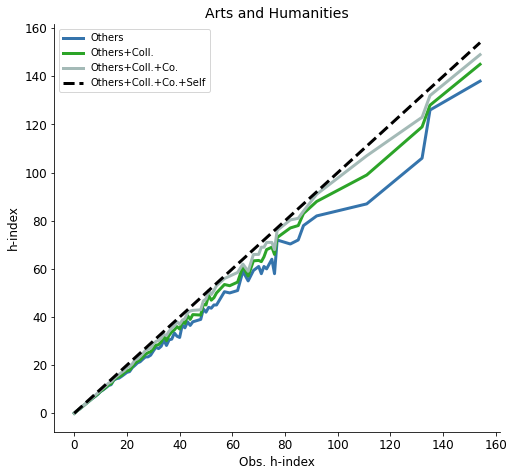

In [18]:

plt.figure(figsize=(8,7.5))
ax = plt.axes()
plt.title(group,fontsize=14)


plt.plot(stats['h_oncs_x'],stats['h_o'],label='Others',color=colors[0],linewidth=3)
plt.plot(stats['h_oncs_x'],stats['h_on'],label='Others+Coll.',color=colors[1],linewidth=3)
plt.plot(stats['h_oncs_x'],stats['h_onc'],label='Others+Coll.+Co.',color=colors[2],linewidth=3)
plt.plot(stats['h_oncs_x'],stats['h_oncs'],'k--',label='Others+Coll.+Co.+Self',linewidth=3)
plt.ylabel('h-index',fontsize=12)
plt.xlabel('Obs. h-index',fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.tick_params(labelsize=12)

plt.legend()
out_path = path+'results/h-index/'
plt.show()


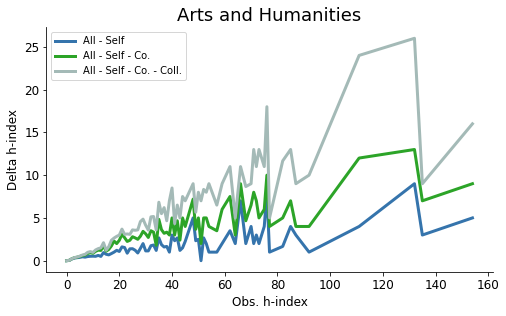

In [24]:
plt.figure(figsize=(8,4.5))
ax = plt.axes()
plt.title(group,fontsize=18)

plt.plot(stats['h_oncs_x'],stats['d_s'],label='All - Self',color=colors[0],linewidth=3)
plt.plot(stats['h_oncs_x'],stats['d_sc'],label='All - Self - Co.',color=colors[1],linewidth=3)
plt.plot(stats['h_oncs_x'],stats['d_scn'],label='All - Self - Co. - Coll.',color=colors[2],linewidth=3)

plt.ylabel('Delta h-index',fontsize=12)
plt.xlabel('Obs. h-index',fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.tick_params(labelsize=12)
plt.legend()
out_path = path+'results/h-index/'
plt.show()

